<a href="https://colab.research.google.com/github/Cesare-Caputo/RL-stuff/blob/main/stochastic_search_RL_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment:dynamic system

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import scipy.integrate as scp
import copy
import numpy.random as rnd
import time
import gym
#import or_gym
#from or_gym.utils import create_env
#import base_algorithm as bAlg

#mazelab

In [ ]:
### including all in one code cell
import gym
from gym.spaces import Box
from gym.spaces import Discrete

from dataclasses import dataclass
from dataclasses import field
@dataclass
class Object:
    r"""Defines an object with some of its properties.

    An object can be an obstacle, free space or food etc. It can also have properties like impassable, positions.

    """
    name: str
    value: int
    rgb: tuple
    impassable: bool
    positions: list = field(default_factory=list)


from abc import ABC
from abc import abstractmethod

from collections import namedtuple
import numpy as np

#from .object import Object


class BaseMaze(ABC):
    def __init__(self, **kwargs):
        objects = self.make_objects()
        assert all([isinstance(obj, Object) for obj in objects])
        self.objects = namedtuple('Objects', map(lambda x: x.name, objects), defaults=objects)()

        for key, value in kwargs.items():
            setattr(self, key, value)

    @property
    @abstractmethod
    def size(self):
        r"""Returns a pair of (height, width). """
        pass

    @abstractmethod
    def make_objects(self):
        r"""Returns a list of defined objects. """
        pass

    def _convert(self, x, name):
        for obj in self.objects:
            pos = np.asarray(obj.positions)
            x[pos[:, 0], pos[:, 1]] = getattr(obj, name, None)
        return x

    def to_name(self):
        x = np.empty(self.size, dtype=object)
        return self._convert(x, 'name')

    def to_value(self):
        x = np.empty(self.size, dtype=int)
        return self._convert(x, 'value')

    def to_rgb(self):
        x = np.empty((*self.size, 3), dtype=np.uint8)
        return self._convert(x, 'rgb')

    def to_impassable(self):
        x = np.empty(self.size, dtype=bool)
        return self._convert(x, 'impassable')

    def __repr__(self):
        return f'{self.__class__.__name__}{self.size}'


from collections import namedtuple


VonNeumannMotion = namedtuple('VonNeumannMotion',
                              ['north', 'south', 'west', 'east'],
                              defaults=[[-1, 0], [1, 0], [0, -1], [0, 1]])


MooreMotion = namedtuple('MooreMotion',
                         ['north', 'south', 'west', 'east',
                          'northwest', 'northeast', 'southwest', 'southeast'],
                         defaults=[[-1, 0], [1, 0], [0, -1], [0, 1],
                                   [-1, -1], [-1, 1], [1, -1], [1, 1]])

from abc import ABC
from abc import abstractmethod

import numpy as np
import gym
from gym.utils import seeding
from PIL import Image


class BaseEnv(gym.Env, ABC):
    metadata = {'render.modes': ['human', 'rgb_array'],
                'video.frames_per_second' : 3}
    reward_range = (-float('inf'), float('inf'))

    def __init__(self):
        self.viewer = None
        self.seed()

    @abstractmethod
    def step(self, action):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    @abstractmethod
    def reset(self):
        pass

    @abstractmethod
    def get_image(self):
        pass

    def render(self, mode='human', max_width=500):
        img = self.get_image()
        img = np.asarray(img).astype(np.uint8)
        img_height, img_width = img.shape[:2]
        ratio = max_width/img_width
        img = Image.fromarray(img).resize([int(ratio*img_width), int(ratio*img_height)])
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)

            return self.viewer.isopen

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

from dataclasses import dataclass


@dataclass
# class DeepMindColor:
#     obstacle = (160, 160, 160)
#     free = (224, 224, 224)
#     agent = (51, 153, 255)
#     goal = (51, 255, 51)
#     button = (102, 0, 204)
#     interruption = (255, 0, 255)
#     box = (0, 102, 102)
#     lava = (255, 0, 0)
#     water = (0, 0, 255)

## this one is better for smaller maze and david silver style
class color:
    obstacle = (0, 0, 0)
    free = (255, 255, 255)
    agent = (255, 51, 51)
    goal = (51, 255, 51)
    button = (102, 0, 204)
    interruption = (255, 0, 255)
    box = (0, 102, 102)
    lava = (255, 0, 0)
    water = (0, 0, 255)


import numpy as np


def random_maze(width=81, height=51, complexity=.75, density=.75):
    r"""Generate a random maze array.

    It only contains two kind of objects, obstacle and free space. The numerical value for obstacle
    is ``1`` and for free space is ``0``.

    Code from https://en.wikipedia.org/wiki/Maze_generation_algorithm
    """
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1]//2 + 1) * 2, np.random.randint(0, shape[0]//2 + 1) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    return Z.astype(int)



class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape

    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal


class Env(BaseEnv):
    def __init__(self):
        super().__init__()

        self.maze = Maze()
        self.motions = VonNeumannMotion()

        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))

    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]

        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}

    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()

    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable

    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out

    def get_image(self):
        return self.maze.to_rgb()

# Neural networks

In [ ]:
class Net(torch.nn.Module):
  def __init__(self, **kwargs):
    super(Net, self).__init__()

    # Unpack the dictionary
    self.args     = kwargs
    self.dtype    = torch.float
    self.use_cuda = torch.cuda.is_available()
    self.device   = torch.device("cpu")

    # defining ANN topology
    self.input_size = self.args['input_size']
    self.hs1        = self.args['hs1']
    self.hs2        = self.args['hs2']
    self.output_sz  = self.args['output_size']

    # defining activation functions
    self.tanh   = torch.nn.Tanh()

    # connect the layers
    self.hidden1 = torch.nn.RNN(self.input_size, self.hs1)
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)

    # defining output layer
    self.output = torch.nn.Linear(self.hs2, self.output_sz)
    self.reset_hn()

  def forward(self, x):
    x           = torch.tensor(x.view(1,1,-1)).float()
    a1, self.hn = self.hidden1(x, self.hn)
    a2          = self.tanh(self.hidden2(a1))
    y           = self.tanh(self.output(a2))

    y = mean_std(y)

    return y.detach().numpy()

  def reset_hn(self):
    self.hn = None
    return



In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

class BaseModel:
    def get_weight(self):
        weight = []
        for param in self.parameters():
            weight.append(param.data.numpy().flatten())
        weight = np.concatenate(weight, 0)
        return weight

    def set_weight(self, solution):
        offset = 0
        for param in self.parameters():
            param_shape = param.data.numpy().shape
            param_size = np.prod(param_shape)
            src_param = solution[offset: offset + param_size]
            if len(param_shape) > 1:
                src_param = src_param.reshape(param_shape)
            param.data = torch.FloatTensor(src_param)
            offset += param_size
        assert offset == len(solution)

class StandardFCNet(nn.Module, BaseModel):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(StandardFCNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = Variable(torch.FloatTensor(x))
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def mean_std(m, mean_ub=[200., 200., 200.], mean_lb=[0., 0., 0.]):
    '''
    Problem specific restrinctions on predicted mean and standard deviation.
    '''

    # mean = torch.tensor(mean_ub) * (m+1)/2 + torch.tensor(mean_lb)

    mean = (torch.tensor(mean_ub) - torch.tensor(mean_lb))* (m-1)/2 + torch.tensor(mean_ub)

    return mean

# Simulation

##load stupid maze

In [ ]:
x = np.load("stupid-maze.npy")
print(x)

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


In [ ]:
start_idx = [[4, 1]]
goal_idx = [[49, 48]]
env_id = 'RandomMaze50by50-v1'


gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=2000)


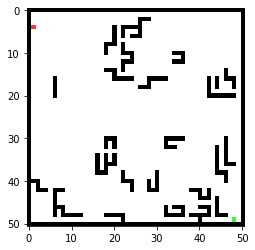

In [ ]:
env = gym.make(env_id)
obs = env.reset()
screen = env.render(mode = 'rgb_array', max_width = 51)
plt.imshow(screen)

## OLD simulation class

In [ ]:
class Simulation(object):
  def __init__(self, env, sample_size, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **kwargs):
    # --- unpacking arguments --- #
    self.sample_size = sample_size
    self.nu, self.nx = nu, nx
    self.l2_regc =  l2_regc
    self.u_min, self.u_max, self.x_mean, self.x_std  = u_min, u_max, x_mean, x_std
    self.policy = Net(**kwargs)
    self.env = env
    #self.env = or_gym.make('InvManagement-v1',env_config = {})
    # self.env = ps_gym.make('SingleStageParallel-v0', env_config = {})

  ############################
  # Sample episodes function #
  ############################

  def load_params(self, x):
    # --- unpacking arguments --- #
    policy = self.policy

    layers = [xt1.data for xt1 in policy.parameters()]
    indx_l = np.array(0)
    indx   = np.array(0)
    for i in range(len(layers)):
      try:
        dim = layers[i].data.shape[0] * layers[i].data.shape[1]
      except:
        dim = layers[i].data.shape[0]

      # transfer x value to parameters of neural network
      indx += np.array(dim)
      layers[i].data.copy_(torch.tensor(x[indx_l:indx]).reshape(layers[i].data.shape))
      indx_l = indx.copy()

    self.policy = policy

    return self.policy

  def RL_simulation(self,x, validate = False):
      '''
      Perform all the MC's for a given candidate. This means we either evaluate the candidate once
      in the case of a deterministic system and 50+ evaluations for stochastic systems.

      input: Policy, physical system, specifications
      output: expected reward, historical data
      '''
      # --- unpacking arguments --- #
      nu, nx =  self.nu, self.nx
      l2_regc =  self.l2_regc
      u_min, u_max, x_std, x_mean  = self.u_min, self.u_max, self.x_std, self.x_mean
      sample_size = self.sample_size
      env = self.env
      # -- initial conditions -- #

      # ----- internal definitions ----- #
      rewards = []
      states  = []
      controls = []
      termin  = []
      rave    = []
      # historical data

      # load parameters of current sample
      policy1 = self.load_params(x)

      # ----- loop over a number of episodes ----- #

      for ep in range(sample_size):
            state = env.reset()
            # print('available controls', control_set['control_set'])
            r = 0
            t= 0
            policy1.reset_hn()
            while True:
                #assert (env.observation_space.contains(state),
                 #   f"State out of range of observation space: {state}")

                # ----- normalizing inputs ----- #
                x_k_norm = (state - x_mean)/x_std
                # ----- Compute next control action ----- #
                x_k_norm_torch          = torch.tensor((x_k_norm))
                mean_uk                 = policy1(x_k_norm_torch)
                u_k                     = np.squeeze(mean_uk)
                u_k                     = np.round(u_k)
                # u_k                     = np.reshape(mean_uk, (nu, 1))
                # u_k                     = env._round2nearest(u_k)
                # ----- hard bounds on constraints ----- #
                for i_u in range(len(u_min)):
                    if u_k[i_u]  < u_min[i_u]:
                        u_k[i_u] = u_min[i_u]
                    if u_k[i_u]  > u_max[i_u]:
                        u_k[i_u] = u_max[i_u]

                state, reward, done, info = env.step(u_k)  #action
                r+=reward
                t+=1
                rewards.append(reward), states.append(state), controls.append(u_k), termin.append(done)

                if done:
                    # print(f'completed episode @ timestep {t}')
                    break

            # parms = policy1.parameters()
            # p_track = 0
            # for param in parms:
            #   p_track += param.pow(2).sum() * l2_regc

            # r -= p_track
            rave.append(r)



      assert done
        #env.generate_schedule()

      # print('average reward', np.mean(rave))

      # ----- Compute expectation and std pf reward ----- #
      reward_mean = np.mean(rave)
      reward_std  = np.std(rave)

      # ----- Return ----- #
      if validate:
        # env.generate_schedule('picture')
        return reward_mean, reward_std , rave, controls
      if not validate:
        return -reward_mean, reward_std



##edited simulation

In [ ]:
class Simulation2(object):
  def __init__(self, env, sample_size, l2_regc, **kwargs):
    # --- unpacking arguments --- #
    self.sample_size = sample_size
    #self.nu, self.nx = nu, nx
    self.l2_regc =  l2_regc
    #self.u_min, self.u_max, self.x_mean, self.x_std  = u_min, u_max, x_mean, x_std
    self.policy = Net(**kwargs)
    self.env = env
    #self.env = or_gym.make('InvManagement-v1',env_config = {})
    # self.env = ps_gym.make('SingleStageParallel-v0', env_config = {})

  ############################
  # Sample episodes function #
  ############################

  def load_params(self, x):
    # --- unpacking arguments --- #
    policy = self.policy

    layers = [xt1.data for xt1 in policy.parameters()]
    indx_l = np.array(0)
    indx   = np.array(0)
    for i in range(len(layers)):
      try:
        dim = layers[i].data.shape[0] * layers[i].data.shape[1]
      except:
        dim = layers[i].data.shape[0]

      # transfer x value to parameters of neural network
      indx += np.array(dim)
      layers[i].data.copy_(torch.tensor(x[indx_l:indx]).reshape(layers[i].data.shape))
      indx_l = indx.copy()

    self.policy = policy

    return self.policy

  def RL_simulation(self,x, validate = False):
      '''
      Perform all the MC's for a given candidate. This means we either evaluate the candidate once
      in the case of a deterministic system and 50+ evaluations for stochastic systems.

      input: Policy, physical system, specifications
      output: expected reward, historical data
      '''
      # --- unpacking arguments --- #
      #nu, nx =  self.nu, self.nx
      l2_regc =  self.l2_regc
      #u_min, u_max, x_std, x_mean  = self.u_min, self.u_max, self.x_std, self.x_mean
      sample_size = self.sample_size
      env = self.env
      # -- initial conditions -- #

      # ----- internal definitions ----- #
      rewards = []
      states  = []
      controls = []
      termin  = []
      rave    = []
      # historical data

      # load parameters of current sample
      policy1 = self.load_params(x)

      # ----- loop over a number of episodes ----- #

      for ep in range(sample_size):
            state = env.reset()
            # print('available controls', control_set['control_set'])
            r = 0
            t= 0
            policy1.reset_hn()
            while True:
                #assert (env.observation_space.contains(state),
                 #   f"State out of range of observation space: {state}")

                # ----- normalizing inputs ----- #
                #x_k_norm = (state - x_mean)/x_std
                x_k_norm = state
                # ----- Compute next control action ----- #
                x_k_norm_torch          = torch.tensor((x_k_norm))
                mean_uk                 = policy1(x_k_norm_torch)
                u_k                     = np.squeeze(mean_uk)
                u_k                     = np.round(u_k)
                # u_k                     = np.reshape(mean_uk, (nu, 1))
                # u_k                     = env._round2nearest(u_k)
                # ----- hard bounds on constraints ----- #
                #for i_u in range(len(u_min)):
                    #if u_k[i_u]  < u_min[i_u]:
                        #u_k[i_u] = u_min[i_u]
                    #if u_k[i_u]  > u_max[i_u]:
                        #u_k[i_u] = u_max[i_u]

                state, reward, done, info = env.step(u_k)  #action
                r+=reward
                t+=1
                rewards.append(reward), states.append(state), controls.append(u_k), termin.append(done)

                if done:
                    # print(f'completed episode @ timestep {t}')
                    break

            # parms = policy1.parameters()
            # p_track = 0
            # for param in parms:
            #   p_track += param.pow(2).sum() * l2_regc

            # r -= p_track
            rave.append(r)



      assert done
        #env.generate_schedule()

      # print('average reward', np.mean(rave))

      # ----- Compute expectation and std pf reward ----- #
      reward_mean = np.mean(rave)
      reward_std  = np.std(rave)

      # ----- Return ----- #
      if validate:
        # env.generate_schedule('picture')
        return reward_mean, reward_std , rave, controls
      if not validate:
        return -reward_mean, reward_std



In [ ]:
env.action_space.n

4

In [ ]:
env.observation_space.shape[0]

51

# Algorithms

## Simulated annealing

In [ ]:

class SA():

    def __init__(self,interval,dim,function,T_max=200, T_min=1, iterMax=60, rate=0.95):
        self.interval = interval                                    # Given state space-the space to be solved
        self.T_max = T_max                                          # Initial annealing temperature-upper temperature limit
        self.T_min = T_min                                          # Lower limit of annealing temperature
        self.iterMax = iterMax                                      # Number of internal iterations at constant temperature
        self.rate = rate                                            # Set cooling parameters,T(k)=rate*T(k-1)
        self.dim = dim
        #############################################################
        self.x_seed = []
        for i in range(self.dim):
            self.x_seed.append(random.uniform(interval[0], interval[1]))

        self.func = function
        #############################################################
        #self.solve()                                                # Seeds in solution space


    def solve(self):
        x1 = np.array(self.x_seed)                                            # Initial x
        T = self.T_max
        value = [-self.func(x1)]
        start = time.perf_counter()
        time1 = [0]
        countSA = 0
        evalSA = [0]                                         # The initial temperature
        while T >= self.T_min:
            countSA += 1
            for i in range(self.iterMax):
                y = self.func(x1)
                delta_x = []
                for idex in range(self.dim):
                  delta_x.append(np.random.uniform(-1,1))
                xNew = self.getNewList(x1,delta_x,self.interval[1],self.interval[0])

                yNew = self.func(xNew)
                delta_y = yNew - y

                x1 = self.deal_min(x1, xNew, delta_y, T)

            if value[-1] < -self.func(x1):
                value.append(-self.func(x1))
            else:
                value.append(value[-1])
            end = time.perf_counter()
            time1.append(end - start)
            evalSA.append(countSA*self.iterMax)
            T *= self.rate
        x_best = x1                                            # Extract the final annealing solution
        print('SA Optimum at: ',x_best,'\n','Function at optimum: ',self.func(x_best))

        return x_best , self.func(x_best) , value , time1 ,evalSA

    def getNewList(self,list1, list2, upper_bound, lower_bound):
        new_list = []
        for idx in range(len(list1)):
            if list1[idx] + list2[idx] >= upper_bound or list1[idx] + list2[idx] <= lower_bound:
                new_list.append(list1[idx] - list2[idx])
            else:
                new_list.append(list1[idx] + list2[idx])
        return np.array(new_list)

    def p_min(self, delta, T):
        probability = np.exp(-delta/T)
        return probability


    def deal_min(self, x1, xNew, delta, T):
        if delta < 0:
            return xNew
        else:
            P = self.p_min(delta, T)
            if P > np.random.uniform(0, 1): return xNew
            else: return x1


## Artificial bee colony algorithm

In [ ]:

def getMatrix(num_range, n, m):
    low = num_range[0]
    up = num_range[1]
    result = []

    for i in range(n):
        item_list = []
        for j in range(m):
            item_list.append(random.uniform(low, up))
        result.append(item_list)

    return np.array(result) # if require list then change into "return result"

def ABCmethod(Function):
    #Create the matrix of records
    PopPosition = np.zeros([nPop,nVar])
    PopCost = np.zeros([nPop,1])
    Probability = np.zeros([nPop,1])
    BestSol = np.zeros([iter_max+1,nVar])
    BestCost = np.inf*np.ones([iter_max+1,1])
    Mine = np.zeros([nPop,1])

    BestStd = np.zeros([iter_max+1,1])
    Popstd = np.zeros([nPop,1])
    #Initialize the honey source location

    PopPosition = getMatrix(dim_bound,nPop,nVar)

    for i in range(nPop):
        # PopCost[i][0] = Function(PopPosition[i])
        PopCost[i][0], Popstd[i][0] = Function(PopPosition[i])
        if PopCost[i][0] < BestCost[0][0]:
            BestCost[0][0] = PopCost[i][0]
            BestSol[0] = PopPosition[i]

            BestStd[0][0] = Popstd[i][0]

    start = time.perf_counter()
    time1 = [0]
    eval = [0]
    for iter in range(iter_max):
        count = 0

        #employed bees

        #Find the next source of honey
        for i in range(nPop):
            while True:
                k = np.random.randint(0,nPop)
                if k != i:
                    break
            phi = a*(-1+2*np.random.rand(nVar))
            NewPosition = PopPosition[i] + phi*(PopPosition[i]-PopPosition[k])
            NewPosition[:] = np.clip(NewPosition,*dim_bound)

            #Make greedy choices
            # NewCost = Function(NewPosition)
            NewCost, NewStd = Function(NewPosition)
            count+= 1
            if NewCost < PopCost[i][0]:
                PopPosition[i] = NewPosition
                PopCost[i][0] = NewCost
                Popstd[i][0] = NewStd
            else:
                Mine[i][0] = Mine[i][0]+1

        #Follower bees

        #计算选择概率矩阵
        Mean = np.mean(PopCost)
        for i in range(nPop):
            Probability[i][0] = np.exp(-PopCost[i][0]/Mean)
        Probability = Probability/np.sum(Probability)
        CumProb = np.cumsum(Probability)

        for k in range(nOnLooker):

            #Implementation of Roulette Selection Method
            m = 0
            for i in range(nPop):
                m = m + CumProb[i]
                if m >= np.random.rand(1):
                    break

            #Repeated employed bee operations
            while True:
                k = np.random.randint(0,nPop)
                if k != i:
                    break
            phi = a*(-1+2*np.random.rand(nVar))
            NewPosition = PopPosition[i] + phi*(PopPosition[i]-PopPosition[k])
            NewPosition[:] = np.clip(NewPosition,*dim_bound)

            #Make greedy choices
            # NewCost = Function(NewPosition)
            NewCost, NewStd = Function(NewPosition)
            count+=1
            if NewCost < PopCost[i][0]:
                PopPosition[i] = NewPosition
                PopCost[i][0] = NewCost
                Popstd[i][0] = NewStd
            else:
                Mine[i][0] = Mine[i][0]+1

        # Scouter bees
        for i in range(nPop):
            if Mine[i][0] >= L:
                PopPosition[i] = getMatrix(dim_bound,1,nVar)
                # PopCost[i][0] = Function(PopPosition[i])
                PopCost[i][0], Popstd[i][0] = Function(PopPosition[i])
                count += 1
                Mine[i][0] = 0

        # Save the historical best solution
        for i in range(nPop):
            if PopCost[i][0] < BestCost[iter+1][0]:
                BestCost[iter+1][0] = PopCost[i][0]
                BestSol[iter+1] = PopPosition[i]
                BestStd[iter+1][0] = Popstd[i][0]

        end = time.perf_counter()
        time1.append(end - start)
        eval.append(count)

    evaluation = [sum(eval[:x]) for x in range(1,len(eval)+1)]
    return BestSol[-1] , BestCost[-1] , BestCost , BestStd, time1 ,evaluation




## PSO

In [ ]:
def local_best_get(particle_pos,particle_pos_val,p):
    local_best=[0]*p #creating empty local best list
    for j in range(p):  #finding the best particle in each neighbourhood
                        #and storing it in 'local_best'
        local_vals=np.zeros(3)
        local_vals[0]=particle_pos_val[j-2]
        local_vals[1]=particle_pos_val[j-1]
        local_vals[2]=particle_pos_val[j]
        min_index=int(np.argmin(local_vals))
        local_best[j-1]=particle_pos[min_index+j-2][:]
    return np.array(local_best)




def PSUinitiation(f,bounds,p):
    '''
    INPUTS
    f       :function to be searched over
    bounds  :bounds of function in form [[x1,x2],[x3,x4],[x5,x6]...]
    p       :number of particles

    OUTPUTS
    particle_pos      :array of random particle positions
    particle_best     :array of best particle positions (same as current)
    swarm_best        :coordinates of particle with best known position
    particle_velocity :array of random particle velocity arrays
    local_best        :array of the best particle in each neighbourhood
    local_best_fitness:function value evaluated at each local best
    particle_pos_val  :fitness of each particle

    '''
    d=len(bounds) #finding number of dimensions
    particle_pos=np.zeros(p) #creating empty position array
    particle_pos=particle_pos.tolist() #converting array to list
    particle_velocity=particle_pos[:] #empty velocity array
    particle_pos_val=particle_pos[:] #empty value array
    particle_std = particle_pos[:]
    for j in range(p): #iterating ovre the number of particles
        particle_pos[j]=[rnd.uniform(bounds[i][0],bounds[i][1])\
                    for i in range(d)] #random coordinate within bounds
        particle_pos_val[j] ,particle_std[j] =f(particle_pos[j]) #calculating function value
                                            #at each particle
        particle_velocity[j]=[rnd.uniform(-abs(bounds[i][1]-bounds[i][0])\
                    ,abs(bounds[i][1]-bounds[i][0])) for i in range(d)]
                    #creating random velocity values for each dimension

    local_best=local_best_get(particle_pos,particle_pos_val,p)

    swarm_best=particle_pos[np.argmin(particle_pos_val)]#getting the lowest particle value
    particle_best=copy.deepcopy(particle_pos)#setting all particles current positions to best
    return d,np.array(particle_pos), np.array(particle_best), \
                 np.array(swarm_best), np.array(particle_velocity), np.array(local_best), \
                     np.array(particle_pos_val)

def PSUwithinbounds(bounds,particle_pos):
    '''
    DESCRIPTION:
        Checks whether a particle's position is within the bounds of the problem
        and contraints particles within bounds

    INPUTS
    bounds      :bounds of problem in form [[x1,x2],[x3,x4]...]
    particle_pos:coordinates of a particle e.g [p1,p2,p3...]


    '''
    for i in range(len(bounds)):
        if particle_pos[i]<bounds[i][0]: #if particle is less than lower bound
            particle_pos[i]=bounds[i][0]
        elif particle_pos[i]>bounds[i][1]: #if particle is more than higher bound
            particle_pos[i]=bounds[i][1]
    return

def particleswarm(f,bounds,p,c1,c2,vmax,PSOiter):
    '''
    DESCRIPTION
    see https://en.wikipedia.org/wiki/Particle_swarm_optimization

    INPUTS
    f           :function to be optimized
    bounds      :bounds of each dimension in form [[x1,x2],[x3,x4]...]
    p           :number of particles
    c1          :adjustable parameter
    c2          :adjustable parameter
    vmax        :maximum particle velocity
    tol         :tolerance for exit condition

    OUTPUTS
    swarm_best  : coordinates of optimal solution, with regards to exit
                  conditions
    '''
    print('Currently placing particles and giving them random \
    velocities...')
    d,particle_pos, particle_best, swarm_best, particle_velocity, \
        local_best, pos_val \
    = PSUinitiation(f,bounds,p) #initializing various arrays
    old_swarm_best=[0]*d
    c3=c1+c2
    K=2/(abs(2-c3-np.sqrt((c3**2)-(4*c3)))) #creating velocity weighting factor

    it_count=0

    start = time.perf_counter()
    time1 = [0]
    func_eval=[0]
    swarm_best_val, swarm_best_std = f(swarm_best)
    value = [-swarm_best_val]
    stdpso = [swarm_best_std]
    # while (abs(f(old_swarm_best)-f(swarm_best))>tol) & (it_count < 10): #exit condition
    while it_count < PSOiter: #exit condition
        it_count+=1
        if it_count>1000: #every 1000 iterations...
                        #create 'conflict' within the swarm and
                        #give all particles random velocities
            print('Particles are too friendly! Creating conflict...')
            for j in range(p): #iterating ovre the number of particles
                particle_velocity[j]=[(rnd.uniform(-abs(bounds[i][1]-bounds[i][0])\
                    ,abs(bounds[i][1]-bounds[i][0]))) for i in range(d)]
                    #adding random velocity values for each dimension
            it_count=0 #reset iteration count

        for i in range(p): #iterates over each particle
            rp,rg=rnd.uniform(0,1,2) #creates two random numbers between 0-
            particle_velocity[i,:]+=(c1*rp*(particle_best[i,:]-particle_pos[i,:]))
            particle_velocity[i,:]+=(c2*rg*(local_best[i,:]-particle_pos[i,:]))
            particle_velocity[i,:]=particle_velocity[i,:]*K
            if particle_velocity[i].any() > vmax : #is any velocity is greater than vmax
                    particle_velocity[i,:]=vmax #set velocity to vmax
            #all of the above is regarding updating the particle's velocity
            #with regards to various parameters (local_best, p_best etc..)
            particle_pos[i,:]+=particle_velocity[i,:] #updating position

            PSUwithinbounds(bounds,particle_pos[i]) #if particle is out of bounds

            # particle_fitness=f(particle_pos[i])
            particle_fitness, particle_std =f(particle_pos[i])

            if particle_fitness < pos_val[i]:
                particle_best[i,:]=particle_pos[i,:] #checking if new best
                pos_val[i]=particle_fitness
                # f_swarm_best=f(swarm_best)
                # if particle_fitness < f_swarm_best:
                if particle_fitness < swarm_best_val:
                    old_swarm_best=swarm_best[:]
                    swarm_best=copy.deepcopy(particle_best[i,:])
                    swarm_best_val = particle_fitness
                    swarm_best_std = particle_std
                    #print('current function value: ',f(swarm_best))

        local_best=local_best_get(particle_pos,pos_val,p)

        end = time.perf_counter()
        time1.append(end - start)
        func_eval.append(it_count*p)
        value.append(-swarm_best_val)
        stdpso.append(swarm_best_std)
    print('PSO Optimum at: ',swarm_best,'\n','Function at optimum: ',swarm_best_val, '\n', 'function evals:', it_count*p)
    return swarm_best, swarm_best_val , value ,stdpso, time1 ,func_eval


## Evolution strategy

In [ ]:
# find non-zero fitness for selection
def get_fitness(pred): return pred.flatten()

def make_kid(pop, n_kid):
    # generate empty kid holder
    kids = {'DNA': np.empty((n_kid, DNA_SIZE)),'fitness': np.empty((n_kid, 1)), 'std': np.empty((n_kid, 1))}
    kids['mut_strength'] = np.empty_like(kids['DNA'])

    for kv, ks in zip(kids['DNA'], kids['mut_strength']):
        # crossover (roughly half p1 and half p2)
        p1, p2 = np.random.choice(np.arange(POP_SIZE), size=2, replace=False)
        cp = np.random.randint(0, 2, DNA_SIZE, dtype=np.bool_)  # crossover points
        kv[cp] = pop['DNA'][p1, cp]
        kv[~cp] = pop['DNA'][p2, ~cp]
        ks[cp] = pop['mut_strength'][p1, cp]
        ks[~cp] = pop['mut_strength'][p2, ~cp]

        # mutate (change DNA based on normal distribution)
        ks[:] = np.maximum(ks + (np.random.rand(*ks.shape)-0.5), 0.)    # must > 0
        kv += ks * np.random.randn(*kv.shape)
        kv[:] = np.clip(kv, *DNA_BOUND)    # clip the mutated value
    return kids


def kill_bad(pop, kids,function):
    # put pop and kids together
    for key in ['DNA', 'mut_strength','fitness','std']:
        pop[key] = np.vstack((pop[key], kids[key]))

    for i in range(len(pop['DNA'])):
        pop['fitness'][i], pop['std'][i] = function(pop['DNA'][i])

    fitness = get_fitness(pop['fitness'])
    # fitness = get_fitness(F(pop['DNA']))            # calculate global fitness

    idx = np.arange(pop['DNA'].shape[0])
    good_idx = idx[fitness.argsort()][:POP_SIZE]   # selected by fitness ranking (not value)
    for key in ['DNA', 'mut_strength','fitness','std']:
        pop[key] = pop[key][good_idx]
    return pop



def solveES(pop,function):
    initvalue , initstd = function(pop['DNA'][0])
    value = [-initvalue]
    stdvalue = [initstd]
    start = time.perf_counter()
    time1 = [0]
    evalES = [0]
    countES = 0
    for _ in range(N_GENERATIONS):
        countES += 1
        # ES part
        kids = make_kid(pop, N_KID)
        pop = kill_bad(pop, kids,function)   # keep some good parent for elitism

        end = time.perf_counter()
        time1.append(end - start)
        if value[-1] < -(pop['fitness'][0][0]):
            value.append(-(pop['fitness'][0][0]))
            stdvalue.append(pop['std'][0][0])
        else:
            value.append(value[-1])
            stdvalue.append(stdvalue[-1])

        evalES.append(countES*(N_KID))

    return pop['DNA'][0] , pop['fitness'][0] , value , stdvalue, time1 ,evalES



## Simplex

In [ ]:
def nelder_mead(f, dim, bound,
                step=1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=100,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
        @param f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        @param x_start (numpy array): initial position
        @param step (float): look-around radius in initial step
        @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        @max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        @alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)
        return: tuple (best parameter array, best score)
    '''

    # init

    x_start = np.random.uniform(bound[0],bound[1],dim)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        if x[i] > bound[1]:
            x[i] = bound[1]
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    evalsimplex = []
    countsimplex = 0
    valuesimplex = []
    start = time.perf_counter()
    timesimplex = []
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]
        valuesimplex.append(-best)
        evalsimplex.append(countsimplex)
        end = time.perf_counter()
        timesimplex.append(end - start)
        # break after max_iter
        if iters >= max_iter:
            return res[0][0],res[0][1],valuesimplex,timesimplex,evalsimplex

        iters += 1

        # break after no_improv_break iterations with no improvement
        # print ('...best so far:', best)

        # if best < prev_best - no_improve_thr:
        #     no_improv = 0
        #     prev_best = best
        # else:
        #     no_improv += 1

        # if no_improv >= no_improv_break:
        #     return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        xr[:] = np.clip(xr,*bound)
        rscore = f(xr)
        countsimplex += 1
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            xe[:] = np.clip(xe,*bound)
            escore = f(xe)
            countsimplex += 1
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        xc[:] = np.clip(xc,*bound)
        cscore = f(xc)
        countsimplex += 1
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            redx[:] = np.clip(redx,*bound)
            score = f(redx)
            countsimplex += 1
            nres.append([redx, score])
        res = nres

# Maze Trial

##params

In [ ]:
env.observation_space.shape[0]

51

In [ ]:
env.action_space.n

4

In [ ]:
env.observation_space.shape[0]* env.observation_space.shape[1]

2601

In [ ]:
# define policy function to optimise weights of
hypparams = {'input_size': env.observation_space.shape[0]* env.observation_space.shape[1],
          'hs1': 10,
          'hs2': 5,
          'output_size': env.action_space.n}
Qnet = Net(**hypparams)

# find dimensionality of the optimisation problem
# this probably will not work for convolutional layers
params = list(Qnet.parameters())
dim = 0
for p in params:
  try:
    dim += p.shape[0] * p.shape[1]
  except:
    dim += p.shape[0]

print(dim)


26209


In [ ]:
## TRY USING FC NN IMPLEMENTATION
hypparams = {'state_dim': env.observation_space.shape[0],
          'hidden_size': 8,
          'action_dim': env.action_space.n}
Qnet = StandardFCNet(**hypparams)

##TRAINING ES

In [ ]:
print(env.observation_space.shape)

(51, 51)


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = env.observation_space.shape[0]
nu                 = env.action_space.n

episodes           = 10 # 500



l2_regc            = 1e-12


f = Simulation2( env, episodes, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]

# perform optimisation ES
DNA_SIZE = dim             # DNA (real number)
DNA_BOUND = dimension_bounds       # solution upper and lower bounds
N_GENERATIONS = 165
POP_SIZE = 20           # population size
N_KID = 40               # n kids per generation

# pop = dict(DNA= np.random.uniform(DNA_BOUND[0],DNA_BOUND[1],size=(1,DNA_SIZE)).repeat(POP_SIZE, axis=0),   # initialize the pop DNA values
#            mut_strength=np.random.rand(POP_SIZE, DNA_SIZE))
#               # initialize the pop mutation strength values


pop = dict(DNA= np.random.uniform(DNA_BOUND[0],DNA_BOUND[1],size=(POP_SIZE,DNA_SIZE)),   # initialize the pop DNA values
           mut_strength=np.random.rand(POP_SIZE, DNA_SIZE), fitness= np.empty((POP_SIZE, 1)), std= np.empty((POP_SIZE, 1)))

opt_params, opt_val , valueES ,stdES, timeES , evalES = solveES(pop,f.RL_simulation)

meanES=valueES
evalES=episodes*np.array(evalES)

###############
plt.figure()
plt.plot(evalES , meanES)
plt.gca().fill_between(evalES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='C0', alpha=0.2)
plt.xlabel('number of function evaluation')
plt.ylabel('Objective function value')
plt.show()

plt.figure()
plt.plot(timeES,meanES)
plt.gca().fill_between(timeES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='C0', alpha=0.2)
plt.xlabel('time')
plt.ylabel('Objective function value')
plt.show()


print('ES Optimum at: ',opt_params,'\n','Function at optimum: ',opt_val)

reward_meanES, reward_stdES, rewardsES,controlsES = f.RL_simulation(opt_params, validate = True)
print(reward_meanES)

KeyError: ignored

#old results

## ABC(result)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5196/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


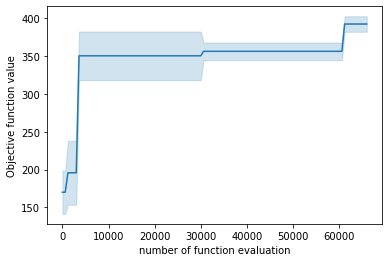

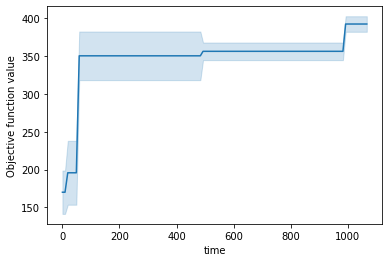

385.01402229919523


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5196/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = 33
nu                 = 3

episodes           = 10 # 500

x_mean             = np.full(33, 100.)
x_std              = np.full(33, 25.)

u_max              = np.array([200., 200., 200.])
u_min              = np.array([0., 0., 0.])


l2_regc            = 1e-12


f = Simulation(episodes, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]
# perform optimisation ABC ##
#Initialize  parameter

nVar = dim
dim_bound = dimension_bounds
#Basic parameters of bee colony algorithm
iter_max = 110
nPop = 40
nOnLooker = 20
L = np.around(0.6*nVar*nPop)
a = 1



opt_params, opt_val , value_ABC ,stdABC, timeABC , evalABC = ABCmethod(f.RL_simulation)
valueABC = -1*np.array(value_ABC)
meanABC  = np.squeeze(valueABC)
stdABC   = np.squeeze(stdABC)
evalABC  = episodes*np.array(evalABC)


####plot#######
plt.figure()
plt.plot(evalABC , meanABC)
plt.gca().fill_between(evalABC, np.array(meanABC) - np.array(stdABC),
                       np.array(meanABC) + np.array(stdABC),
                       color='C0', alpha=0.2)
plt.xlabel('number of function evaluation')
plt.ylabel('Objective function value')
plt.show()

plt.figure()
plt.plot(timeABC,meanABC)
plt.gca().fill_between(timeABC, np.array(meanABC) - np.array(stdABC),
                       np.array(meanABC) + np.array(stdABC),
                       color='C0', alpha=0.2)
plt.xlabel('time')
plt.ylabel('Objective function value')
plt.show()

################

reward_meanABC, reward_stdABC, rewardsABC, controlsABC = f.RL_simulation(opt_params, validate = True)
print(reward_meanABC)


In [ ]:
np.savez('ABC.npz',evalABC = evalABC,timeABC=timeABC,meanABC=meanABC,stdABC=stdABC,solutionABC = opt_params)

## SA(result)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_3684/3249552983.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


SA Optimum at:  [-4.05526562  3.26006036  7.09382714  6.96608637  1.46641672 -9.16446252
  1.21249997  7.35774511  8.47064024  2.2910495  -2.24441433  0.65711371
 -5.82137093 -1.58045567  2.39958813  8.18313822 -3.74387839  6.91798119
  6.30147828 -6.92129388  9.00058321 -6.84960968  4.20195521 -0.41762061
  4.09927696 -3.41096454  4.67442389 -5.92240136  4.91605101 -3.39468568
 -8.15504115 -7.5595682   0.41216519  0.28793149 -3.3828461  -4.92607807
 -5.14824473  0.80443791  5.70785238  3.61463148  5.25355939 -5.77731701
 -2.95717457 -1.783134    5.69873798  5.23703987 -3.642844    3.40585862
  4.21988088 -8.44257518 -4.04771696  1.67002152 -6.83476471 -9.15247458
 -5.12264406  1.36763546 -6.65573604 -4.45481745  7.9483618   6.05271664
 -2.52662798 -4.1814909   0.09181126  7.82057929  1.84406785 -6.40306705
  0.23927045  9.21375134  1.98757968  0.66644798  0.54537059 -1.47196824
 -6.03864608 -0.29340494 -2.19528479 -4.85575938  1.99597539 -3.66995499
  7.50401929  2.65417529  1.9586324

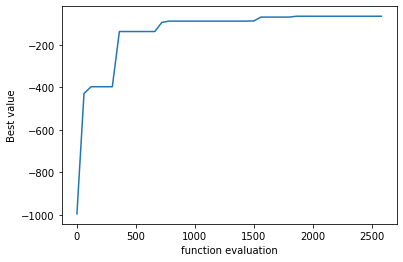

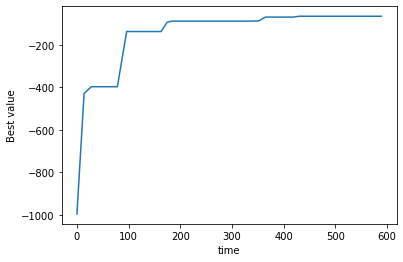

time index pre [28.0, -6.0, 150.0, 0.0]
time index post [28.0, 150.0]
time index pre [-48.0, 108.0, 0.0]
time index post [108.0]
time index pre [-42.0, 42.0, -8.0, 20.0, -6.0, 36.0, 0.0]
time index post [42.0, 20.0, 36.0]
time index pre [-30.0, 50.0, -8.0, 256.0, 0.0]
time index post [50.0, 256.0]


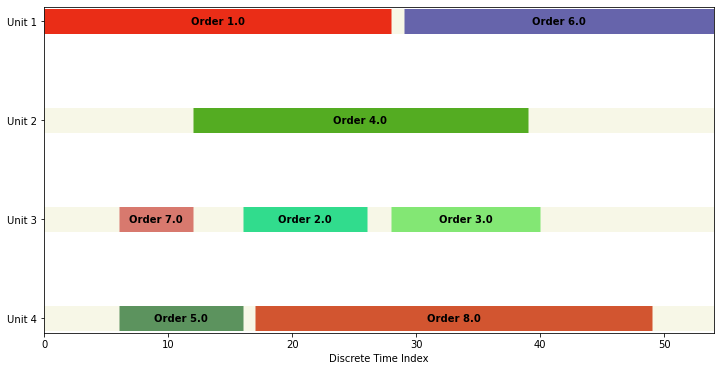

-65.0


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = 25
nu                 = 4

episodes           = 1 # 500

x_mean             = np.full(25, 500.)
x_std              = np.full(25, 125.)

u_max              = np.array([8., 8., 8., 8.])
u_min              = np.array([0., 0., 0., 0.])


l2_regc            = 1e-12


f = Simulation(episodes, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]
#
sa = SA([-10.0, 10.0],dim,f.RL_simulation,T_max=1000, T_min=1, iterMax=60, rate=0.85)
opt_params, opt_val , valueSA , timeSA ,evalSA  = sa.solve()

plt.figure()
plt.plot(evalSA,valueSA)
plt.xlabel('function evaluation')
plt.ylabel('Best value')
plt.show()

plt.figure()
plt.plot(timeSA,valueSA)
plt.xlabel('time')
plt.ylabel('Best value')
plt.show()

reward_mean, reward_std, rewards = f.RL_simulation(opt_params, validate = True)
print(reward_mean)


## PSO(result)

Currently placing particles and giving them random     velocities...


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5940/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


PSO Optimum at:  [  4.87147654   5.82479894  -4.24034317  -5.44772945  -7.47033694
   9.82343478  -7.89973271  -9.02685976  -8.76224642  -7.19266805
  -5.83738794  -3.30532364  -8.63687794  -7.24626017   7.4125734
  -8.28876361   8.08962484   8.28196662  -8.49505412   7.99455954
  -4.41031185  -2.41882975   8.8286987   -1.76755808 -10.
   4.5475779   -8.47356431  -7.51288397   6.45267078   6.50819242
   5.24206161   8.26875887   4.07500136   7.99559852   7.23530705
   9.01680229  -7.00854331   8.22914027  -7.57151823   9.49665627
   7.2587252   -9.03247385   9.50659094  -9.69024587   5.58581763
  -6.74417713   6.43453482   8.75425732   9.00819817   7.45807294
   8.22537402  -8.83567556  -4.89561181   4.76863541  -7.97050096
  -5.32307843   9.66357542   9.03689698  -5.07600648  -1.63856789
  -7.80437637  -7.56624379   5.38277052   2.22911759   5.05957528
   3.44515686  -7.07606929  -7.55362546  -6.2202498   -9.60502768
  -9.12586713  -1.40825007  -7.97978777   7.84480549  -5.62495391
  

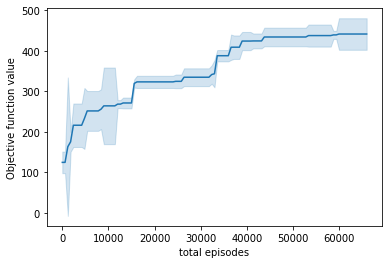

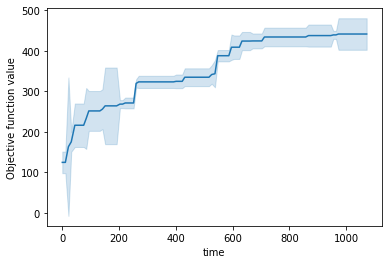

423.7828269775374


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5940/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = 33
nu                 = 3

episodes           = 10 # 500

x_mean             = np.full(33, 100.)
x_std              = np.full(33, 25.)

u_max              = np.array([200., 200., 200.])
u_min              = np.array([0., 0., 0.])


l2_regc            = 1e-12


f = Simulation(episodes, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]

p=60 #shouldn't really change
vmax=(dimension_bounds[1]-dimension_bounds[0])*0.75
c1=2.8 #shouldn't really change
c2=1.3 #shouldn't really change
PSOiter = 110




opt_params, opt_val , valuePSO , stdPSO, timePSO ,evalPSO = particleswarm(f.RL_simulation,bounds,p,c1,c2,vmax,PSOiter)
meanPSO= valuePSO
evalPSO= episodes*np.array(evalPSO)

plt.figure()
plt.plot(evalPSO , meanPSO)
plt.gca().fill_between(evalPSO, np.array(meanPSO) - np.array(stdPSO),
                       np.array(meanPSO) + np.array(stdPSO),
                       color='C0', alpha=0.2)
plt.xlabel('total episodes')
plt.ylabel('Objective function value')
plt.show()

plt.figure()
plt.plot(timePSO,meanPSO)
plt.gca().fill_between(timePSO, np.array(meanPSO) - np.array(stdPSO),
                       np.array(meanPSO) + np.array(stdPSO),
                       color='C0', alpha=0.2)
plt.xlabel('time')
plt.ylabel('Objective function value')
plt.show()

reward_meanPSO, reward_stdPSO, rewardsPSO, controlsPSO = f.RL_simulation(opt_params, validate = True)
print(reward_meanPSO)

In [ ]:
np.savez('PSO.npz',evalPSO = evalPSO,timePSO=timePSO,meanPSO=meanPSO,stdPSO=stdPSO,solutionPSO = opt_params)

# ES(result)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_6300/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


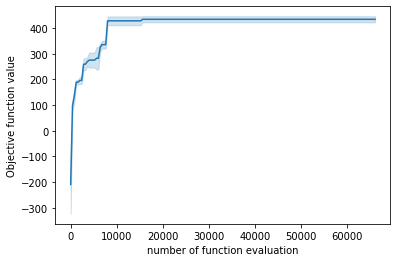

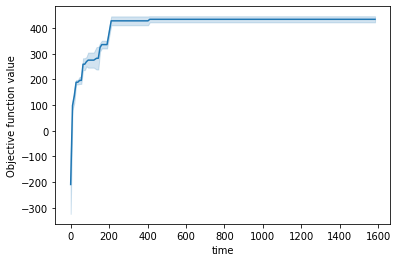

ES Optimum at:  [ 1.60756877e-03  1.28274489e+00  5.45176652e+00 -4.86578387e+00
  2.47560979e+00  2.98873903e+00 -3.69349260e+00  1.00000000e+01
 -9.10410986e+00 -7.61275505e+00  5.25035138e+00 -4.01395258e+00
  1.60094230e+00  1.57196263e+00 -1.00000000e+01  8.48361792e+00
 -3.85504815e-01  6.65231160e+00  4.23682789e+00  7.86027604e+00
  3.35823180e+00  9.96271230e+00 -1.00000000e+01  2.35537259e-01
 -9.78197307e+00  8.96439595e+00 -5.12088969e+00  3.60337830e+00
 -1.00000000e+01  2.28625642e+00 -5.91156635e+00  2.84077973e+00
  3.37383795e+00  5.73181572e+00 -8.83854220e+00  1.44760346e+00
  9.44893600e+00 -3.15848619e+00  3.46952643e+00  1.56746278e+00
  9.52111144e+00 -4.63101718e+00  4.76787229e+00  8.64919845e-01
  3.33533431e+00  2.73005591e+00  8.72190575e+00 -7.94285848e+00
  5.86192928e+00 -5.37435645e-01  1.50632110e+00  6.25361291e+00
  6.03901873e+00 -8.34226216e+00 -2.02206378e+00  1.33944316e+00
 -3.34996625e+00 -2.90524448e+00 -4.36208085e+00 -9.81283257e+00
  8.51841

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_6300/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = 33
nu                 = 4

episodes           = 10 # 500

x_mean             = np.full(33, 100.)
x_std              = np.full(33, 25.)

u_max              = np.array([200., 200., 200.])
u_min              = np.array([0., 0., 0.])


l2_regc            = 1e-12


f = Simulation(episodes, env, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]

# perform optimisation ES
DNA_SIZE = dim             # DNA (real number)
DNA_BOUND = dimension_bounds       # solution upper and lower bounds
N_GENERATIONS = 165
POP_SIZE = 20           # population size
N_KID = 40               # n kids per generation

# pop = dict(DNA= np.random.uniform(DNA_BOUND[0],DNA_BOUND[1],size=(1,DNA_SIZE)).repeat(POP_SIZE, axis=0),   # initialize the pop DNA values
#            mut_strength=np.random.rand(POP_SIZE, DNA_SIZE))
#               # initialize the pop mutation strength values


pop = dict(DNA= np.random.uniform(DNA_BOUND[0],DNA_BOUND[1],size=(POP_SIZE,DNA_SIZE)),   # initialize the pop DNA values
           mut_strength=np.random.rand(POP_SIZE, DNA_SIZE), fitness= np.empty((POP_SIZE, 1)), std= np.empty((POP_SIZE, 1)))
opt_params, opt_val , valueES ,stdES, timeES , evalES = solveES(pop,f.RL_simulation)

meanES=valueES
evalES=episodes*np.array(evalES)

###############
plt.figure()
plt.plot(evalES , meanES)
plt.gca().fill_between(evalES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='C0', alpha=0.2)
plt.xlabel('number of function evaluation')
plt.ylabel('Objective function value')
plt.show()

plt.figure()
plt.plot(timeES,meanES)
plt.gca().fill_between(timeES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='C0', alpha=0.2)
plt.xlabel('time')
plt.ylabel('Objective function value')
plt.show()


print('ES Optimum at: ',opt_params,'\n','Function at optimum: ',opt_val)

reward_meanES, reward_stdES, rewardsES,controlsES = f.RL_simulation(opt_params, validate = True)
print(reward_meanES)



In [ ]:
np.savez('ES.npz',evalES = evalES,timeES=timeES,meanES=meanES,stdES=stdES,solutionES = opt_params)

## hybrid

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_4012/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


Best solution:  [ 10.          -3.16642802   2.14209367  10.          -9.36962809
 -10.           5.01105439  10.          10.          10.
  -4.55963946   5.07857734   9.29553067 -10.           2.25603287
  10.          10.         -10.          10.         -10.
   0.88503574 -10.          10.          10.           4.06579063
   4.95803011  -6.63121173   9.64034208  -1.91685952  10.
  10.         -10.         -10.          10.         -10.
  -9.0811443    6.60139569  10.          10.         -10.
  -6.12089927   1.92943075   7.37577057 -10.         -10.
  10.           9.90492349  10.         -10.          10.
  10.           9.40798787   6.25209177  10.         -10.
   8.64974911  10.           7.2845076    6.88044911   8.57532282
  10.         -10.           5.60213784 -10.         -10.
  10.          10.          10.          -1.1342412   -9.60481995
  10.           7.89011048  10.           2.78437596  -5.29281429
  -7.07477236 -10.           2.1506113   -0.50007686  10.
 -10.   

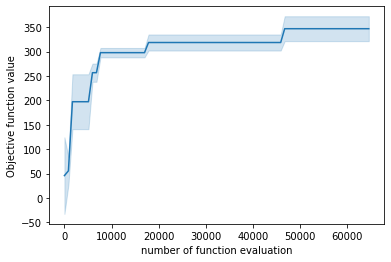

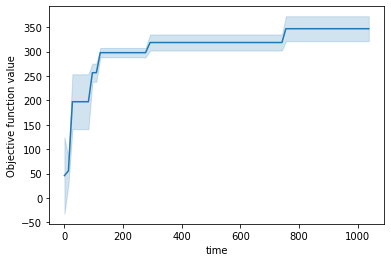

-273.49275198963693


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_4012/4120508519.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x           = torch.tensor(x.view(1,1,-1)).float()


In [ ]:
import datetime

# ---------- set random seed and timers ---------- #
# torch.manual_seed(666)
# now = datetime.datetime.now()
# np.random.seed(seed=0)

# ---------- problem definition ---------- #
   # model parameter definitions

nx                 = 33
nu                 = 3

episodes           = 10 # 500

x_mean             = np.full(33, 100.)
x_std              = np.full(33, 25.)

u_max              = np.array([200., 200., 200.])
u_min              = np.array([0., 0., 0.])


l2_regc            = 1e-12


f = Simulation(episodes, nu, nx, u_min, u_max, x_mean, x_std, l2_regc, **hypparams)

dimensions=dim
dimension_bounds=[-10,10]   # bounds are important here
bounds=[0]*dimensions     #creating n_d dimensional bounds
for i in range(dimensions):
    bounds[i]=dimension_bounds

#creates bounds [[x1,x2],[x3,x4],[x5,x6]....]


"""定义相关参数"""
dimensions= dim
dimension_bounds=[-10,10]   # bounds are important here

PopSize = 60
MaxIter = 75

numRerank = 5

"""
SA参数设置
"""
T_Bound = [1, 200]
T = T_Bound[1]
rate =  0.9
"""
PSO参数设置
"""
VBound = [-(dimension_bounds[1]-dimension_bounds[0])*0.75, (dimension_bounds[1]-dimension_bounds[0])*0.75]
c1=2.8
c2=1.3

"""
ABC参数设置
"""
nOnLooker = 10
L = np.around(0.6 * dimensions * PopSize)
a = 1
"""
ES参数设置
"""
N_KID = 15


"""初始化种群"""
GBest = bAlg.INDIVIDUAL(dimensions, dimension_bounds, f.RL_simulation)
PO = list()
for i in range(PopSize):
    PO.append(bAlg.INDIVIDUAL(dimensions, dimension_bounds, f.RL_simulation))
    PO[i].Calculate()
    if (PO[i].fit < GBest.fit):
        GBest.var = PO[i].var
        GBest.fit = PO[i].fit
        GBest.std = PO[i].std

PO[0].Rank(PO)

"""迭代开始"""

iter = 0
meanhybrid = [-GBest.fit]
stdhybrid = [GBest.std]
evalhybrid = [0]
count = 0
start = time.perf_counter()
timehybrid = [0]
while iter <= MaxIter:

    if iter % numRerank == 0:
        PO0 = list()
        PO1 = list()
        PO2 = list()
        PO3 = list()
        for no in range(len(PO)):
            if PO[no].rank <= 19:
                PO0.append(PO[no])
            if (PO[no].rank > 19) and (PO[no].rank <= 24):
                PO1.append(PO[no])
            if (PO[no].rank > 24) and (PO[no].rank <= 40):
                PO2.append(PO[no])
            if (PO[no].rank > 40) and (PO[no].rank <= 60):
                PO3.append(PO[no])

    T, PO1, GBest , countSA = bAlg.solveSA(PO1, GBest, f.RL_simulation, 1, dimensions, dimension_bounds, T_Bound, T, rate)

    PO0, GBest, countPSO = bAlg.solvePSO(PO0, GBest, f.RL_simulation, dimension_bounds, 1, dimensions, c1, c2,  VBound)

    PO2, GBest ,countABC= bAlg.solveABC(PO2, GBest, f.RL_simulation, dimension_bounds, 1, dimensions, a, nOnLooker, L)

    PO3, GBest ,countES= bAlg.solveES(PO3, GBest, f.RL_simulation, dimension_bounds, 1, dimensions, N_KID)

    if iter % numRerank == 0:
        PO = PO0 + PO1 + PO2 + PO3
        PO[0].Rank(PO)

    end = time.perf_counter()
    timehybrid.append(end - start)
    count += countSA + countPSO + countABC +countES
    evalhybrid.append(count)
    meanhybrid.append(-GBest.fit)
    stdhybrid.append(GBest.std)
    iter += 1

print("Best solution: ", GBest.var)
print("Best value: ", GBest.fit)
opt_params = GBest.var
evalhybrid = episodes*np.array(evalhybrid)

################
plt.figure()
plt.plot(evalhybrid , meanhybrid)
plt.gca().fill_between(evalhybrid, np.array(meanhybrid) - np.array(stdhybrid),
                       np.array(meanhybrid) + np.array(stdhybrid),
                       color='C0', alpha=0.2)
plt.xlabel('number of function evaluation')
plt.ylabel('Objective function value')
plt.show()

plt.figure()
plt.plot(timehybrid,meanhybrid)
plt.gca().fill_between(timehybrid, np.array(meanhybrid) - np.array(stdhybrid),
                       np.array(meanhybrid) + np.array(stdhybrid),
                       color='C0', alpha=0.2)
plt.xlabel('time')
plt.ylabel('Objective function value')
plt.show()

reward_meanHB, reward_stdHB, rewardsHB, controlsHB = f.RL_simulation(opt_params, validate = True)
print(reward_meanHB)


In [ ]:
print(meanhybrid)

[124.26251119998915, 164.69588208812317, 173.40923674992274, 173.40923674992274, 212.47003491388506, 212.47003491388506, 212.47003491388506, 226.580251739708, 226.580251739708, 388.67616076206605, 388.67616076206605, 392.33259566577874, 392.33259566577874, 392.33259566577874, 392.33259566577874, 392.33259566577874, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 396.0148843868645, 398.51293882526846, 398.51293882526846, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 401.77905779935065, 403.66698601853403, 403.66698601853403, 403.66698601853403, 403.66698601853403, 403.66698601853403, 403.666986018534

In [ ]:
np.savez('hybrid.npz',evalhybrid = evalhybrid,timehybrid=timehybrid,meanhybrid=meanhybrid,stdhybrid=stdhybrid, solutionhybrid=opt_params)

## comparison

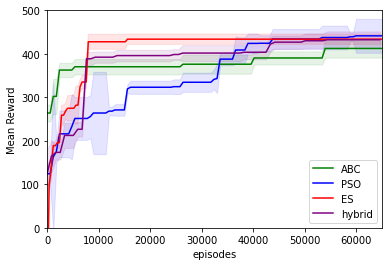

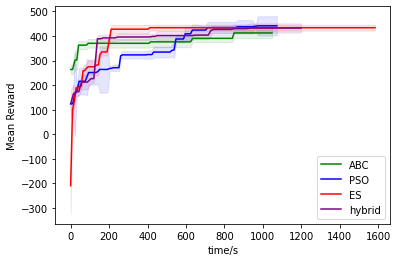

In [ ]:
PSOdate=np.load('PSO.npz')
evalPSO=PSOdate['evalPSO']
timePSO=PSOdate['timePSO']
meanPSO=PSOdate['meanPSO']
stdPSO=PSOdate['stdPSO']

ABCdate=np.load('ABC.npz')
evalABC=ABCdate['evalABC']
timeABC=ABCdate['timeABC']
meanABC=ABCdate['meanABC']
stdABC=ABCdate['stdABC']

ESdate=np.load('ES.npz')
evalES=ESdate['evalES']
timeES=ESdate['timeES']
meanES=ESdate['meanES']
stdES=ESdate['stdES']

HBdate = np.load('hybrid.npz')
evalhybrid = HBdate['evalhybrid']
timehybrid = HBdate['timehybrid']
meanhybrid = HBdate['meanhybrid']
stdhybrid = HBdate['stdhybrid']

# SAdate=np.load('SA.npz')
# evalSA=SAdate['evalSA']
# timeSA=SAdate['timeSA']
# meanSA=SAdate['meanSA']
# stdSA=SAdate['stdSA']

plt.figure()
# plt.plot(evalABC,np.log(np.array(y)),label='ABC')
# plt.plot(evalSA,np.log(np.array(valueSA)),label = 'SA')
# plt.plot(evalPSO , np.log(np.array(valuePSO)),label='PSO')
# plt.plot(evalES ,np.log(np.array(valueES)),label='ES')
# plt.plot(eval, np.log(np.array(trace)),label='hybrid')

plt.plot(evalABC,np.array(meanABC),label='ABC',color='green')
plt.gca().fill_between(evalABC, np.array(meanABC) - np.array(stdABC),
                       np.array(meanABC) + np.array(stdABC),
                       color='green', alpha=0.1)
# plt.plot(evalSA,np.array(meanSA),label = 'SA',color='gold')
# plt.gca().fill_between(evalSA, np.array(meanSA) - np.array(stdSA),
#                        np.array(meanSA) + np.array(stdSA),
#                        color='gold', alpha=0.1)
plt.plot(evalPSO , np.array(meanPSO),label='PSO',color='blue')
plt.gca().fill_between(evalPSO, np.array(meanPSO) - np.array(stdPSO),
                       np.array(meanPSO) + np.array(stdPSO),
                       color='blue', alpha=0.1)
plt.plot(evalES ,np.array(meanES),label='ES',color='red')
plt.gca().fill_between(evalES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='red', alpha=0.1)
plt.plot(evalhybrid, np.array(meanhybrid),label='hybrid',color='purple')
plt.gca().fill_between(evalhybrid, np.array(meanhybrid) - np.array(stdhybrid),
                       np.array(meanhybrid) + np.array(stdhybrid),
                       color='purple', alpha=0.1)
plt.legend()
plt.xlabel('episodes')
plt.ylabel('Mean Reward')
plt.xlim([0,65000])
plt.ylim([0,500])
plt.show()

plt.figure()
plt.plot(timeABC,np.array(meanABC),label='ABC',color='green')
plt.gca().fill_between(timeABC, np.array(meanABC) - np.array(stdABC),
                       np.array(meanABC) + np.array(stdABC),
                       color='green', alpha=0.1)
# plt.plot(timeSA,np.array(meanSA),label = 'SA',color='gold')
# plt.gca().fill_between(timeSA, np.array(meanSA) - np.array(stdSA),
#                        np.array(meanSA) + np.array(stdSA),
#                        color='gold', alpha=0.1)
plt.plot(timePSO , np.array(meanPSO),label='PSO',color='blue')
plt.gca().fill_between(timePSO, np.array(meanPSO) - np.array(stdPSO),
                       np.array(meanPSO) + np.array(stdPSO),
                       color='blue', alpha=0.1)
plt.plot(timeES ,np.array(meanES),label='ES',color='red')
plt.gca().fill_between(timeES, np.array(meanES) - np.array(stdES),
                       np.array(meanES) + np.array(stdES),
                       color='red', alpha=0.1)
plt.plot(timehybrid, np.array(meanhybrid),label='hybrid',color='purple')
plt.gca().fill_between(timehybrid, np.array(meanhybrid) - np.array(stdhybrid),
                       np.array(meanhybrid) + np.array(stdhybrid),
                       color='purple', alpha=0.1)

plt.legend()
plt.xlabel('time/s')
plt.ylabel('Mean Reward')
# plt.xlim([0,100])
# plt.ylim([0,500])
plt.show()